Formato da imagem: (394, 556, 3)
Limiar calculado: 5.528367464004617
Percentual marcado como objeto: 30.922013658109044 %


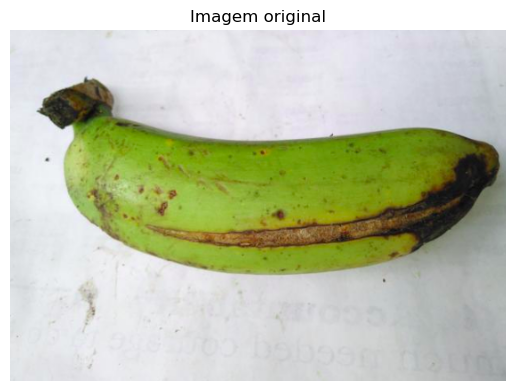

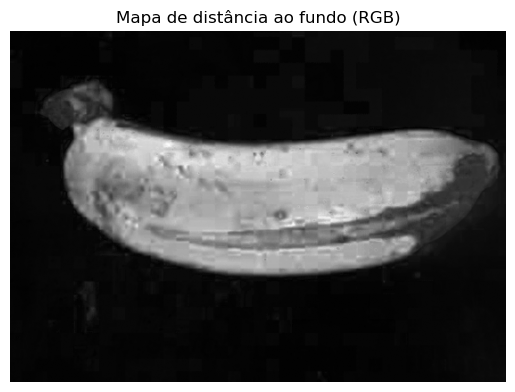

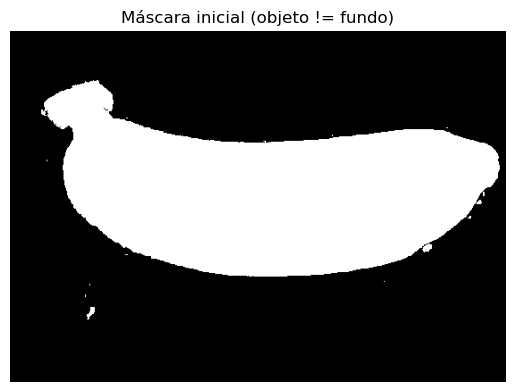

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def carregar_imagem(caminho: str) -> np.ndarray:
    """
    Carrega uma imagem usando matplotlib (sem PIL/OpenCV).
    Retorna um array RGB float em [0, 1].
    """
    img = mpimg.imread(caminho)

    # Converte para float
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32)

    # Normaliza se vier em [0,255]
    if img.max() > 1.5:
        img = img / 255.0

    # Remove canal alpha se existir
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]

    # Se for grayscale, replica para RGB
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)

    return img

def estimar_cor_do_fundo(imagem: np.ndarray, borda: int = 10) -> np.ndarray:
    """
    Estima a cor do fundo usando pixels das bordas.
    Usa a mediana para ser mais robusto a ruído.
    Retorna um vetor [R, G, B].
    """
    h, w, _ = imagem.shape
    b = max(1, min(borda, h // 4, w // 4))

    topo = imagem[:b, :, :]
    baixo = imagem[-b:, :, :]
    esquerda = imagem[:, :b, :]
    direita = imagem[:, -b:, :]

    pixels_borda = np.concatenate([
        topo.reshape(-1, 3),
        baixo.reshape(-1, 3),
        esquerda.reshape(-1, 3),
        direita.reshape(-1, 3),
    ], axis=0)

    cor_fundo = np.median(pixels_borda, axis=0)
    return cor_fundo

def limiar_robusto_pelas_bordas(mapa_dist: np.ndarray, mascara_borda: np.ndarray, k: float = 4.0) -> float:
    """
    Calcula um limiar robusto usando as distâncias na borda (que representam o fundo).
    limiar = mediana + k * MAD (Median Absolute Deviation).
    """
    d = mapa_dist[mascara_borda]
    mediana = np.median(d)
    mad = np.median(np.abs(d - mediana)) + 1e-8
    limiar = mediana + k * mad
    return float(limiar)



def criar_mascara_inicial_objeto_mahalanobis(imagem: np.ndarray, borda: int = 10, q: float = 0.995):
    """
    Máscara inicial usando Mahalanobis (modelo do fundo pelas bordas).
    Limiar por quantil da própria borda (ex: 99.5%).
    """
    h, w, _ = imagem.shape
    b = max(1, min(borda, h // 4, w // 4))

    # máscara borda
    mascara_borda = np.zeros((h, w), dtype=bool)
    mascara_borda[:b, :] = True
    mascara_borda[-b:, :] = True
    mascara_borda[:, :b] = True
    mascara_borda[:, -b:] = True

    # pixels da borda (fundo)
    X = imagem[mascara_borda].reshape(-1, 3)
    mu = np.mean(X, axis=0)

    # covariância + regularização (evita singularidade)
    Xc = X - mu
    cov = (Xc.T @ Xc) / max(1, (Xc.shape[0] - 1))
    cov = cov + 1e-5 * np.eye(3)  # regularização
    inv_cov = np.linalg.inv(cov)

    # Mahalanobis por pixel
    Y = imagem.reshape(-1, 3) - mu
    # d^2 = y^T inv_cov y
    d2 = np.einsum("ij,jk,ik->i", Y, inv_cov, Y)
    mapa = np.sqrt(d2).reshape(h, w)

    # limiar = quantil do fundo (borda)
    limiar = float(np.quantile(mapa[mascara_borda], q))
    mascara = mapa > limiar
    return mascara, mapa, limiar


# =========================
# EXEMPLO DE USO / TESTE
# =========================
caminho_imagem = "teste-banana11.png"  ###### colocar o caminho da imagem aqui
imagem = carregar_imagem(caminho_imagem)

mascara_inicial, mapa_dist, limiar = criar_mascara_inicial_objeto_mahalanobis(imagem, borda=12, q=0.995)


print("Formato da imagem:", imagem.shape)
print("Limiar calculado:", limiar)
print("Percentual marcado como objeto:", mascara_inicial.mean() * 100, "%")

# Visualização
plt.figure()
plt.imshow(imagem)
plt.title("Imagem original")
plt.axis("off")

plt.figure()
plt.imshow(mapa_dist, cmap="gray")
plt.title("Mapa de distância ao fundo (RGB)")
plt.axis("off")

plt.figure()
plt.imshow(mascara_inicial, cmap="gray")
plt.title("Máscara inicial (objeto != fundo)")
plt.axis("off")

plt.show()


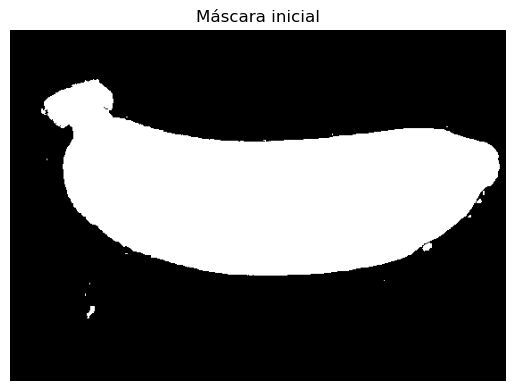

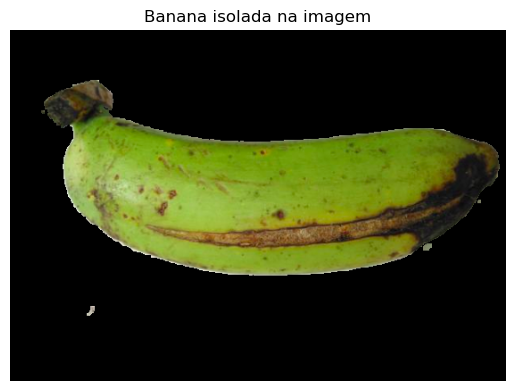

In [208]:
import numpy as np
from collections import deque

def erosao_binaria(mascara: np.ndarray, tamanho: int = 3) -> np.ndarray:
    r = tamanho // 2
    h, w = mascara.shape
    saida = np.zeros_like(mascara, dtype=bool)
    for i in range(r, h - r):
        for j in range(r, w - r):
            janela = mascara[i-r:i+r+1, j-r:j+r+1]
            saida[i, j] = np.all(janela)
    return saida

def dilatacao_binaria(mascara: np.ndarray, tamanho: int = 3) -> np.ndarray:
    r = tamanho // 2
    h, w = mascara.shape
    saida = np.zeros_like(mascara, dtype=bool)
    for i in range(r, h - r):
        for j in range(r, w - r):
            janela = mascara[i-r:i+r+1, j-r:j+r+1]
            saida[i, j] = np.any(janela)
    return saida

def abertura_binaria(mascara: np.ndarray, tamanho: int = 3) -> np.ndarray:
    return dilatacao_binaria(erosao_binaria(mascara, tamanho), tamanho)

def rotular_componentes(mascara: np.ndarray, conectividade: int = 8):
    h, w = mascara.shape
    rotulos = np.zeros((h, w), dtype=np.int32)
    rotulo_atual = 0

    if conectividade == 4:
        vizinhos = [(-1,0),(1,0),(0,-1),(0,1)]
    else:
        vizinhos = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    for i in range(h):
        for j in range(w):
            if mascara[i, j] and rotulos[i, j] == 0:
                rotulo_atual += 1
                fila = deque([(i, j)])
                rotulos[i, j] = rotulo_atual

                while fila:
                    x, y = fila.popleft()
                    for dx, dy in vizinhos:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < h and 0 <= ny < w:
                            if mascara[nx, ny] and rotulos[nx, ny] == 0:
                                rotulos[nx, ny] = rotulo_atual
                                fila.append((nx, ny))

    return rotulos, rotulo_atual



# === APLICAR NO SEU RESULTADO ===
# mascara_inicial = ...

mascara_banana =abertura_binaria(mascara_inicial, tamanho=3)




plt.figure()
plt.imshow(mascara_inicial, cmap="gray")
plt.title("Máscara inicial")
plt.axis("off")



plt.show()


# imagem é o array RGB 
banana_somente = imagem.copy()
banana_somente[~mascara_banana] = 0  # zera o fundo

plt.figure()
plt.imshow(banana_somente)
plt.title("Banana isolada na imagem")
plt.axis("off")
plt.show()


Classificação final: podre
Percentuais: {'verde': 76.39, 'madura': 15.59, 'podre': 8.46}


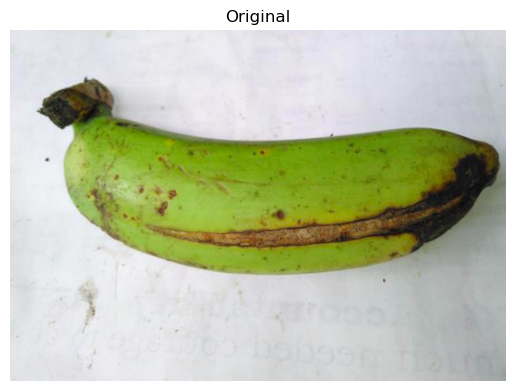

In [209]:


def rgb_para_hsv(imagem_rgb: np.ndarray) -> np.ndarray:
    """
    Converte imagem RGB (float [0,1]) para HSV (H em [0,1], S em [0,1], V em [0,1]).

    """
    r = imagem_rgb[..., 0]
    g = imagem_rgb[..., 1]
    b = imagem_rgb[..., 2]

    cmax = np.maximum(np.maximum(r, g), b)
    cmin = np.minimum(np.minimum(r, g), b)
    delta = cmax - cmin

    h = np.zeros_like(cmax)
    s = np.zeros_like(cmax)
    v = cmax

    # Saturação
    s = np.where(cmax == 0, 0, delta / (cmax + 1e-12))

    # Matiz (Hue)
    # Evita divisão por zero
    delta_seguro = delta + 1e-12

    # Onde cmax == r
    hr = ((g - b) / delta_seguro) % 6
    # Onde cmax == g
    hg = ((b - r) / delta_seguro) + 2
    # Onde cmax == b
    hb = ((r - g) / delta_seguro) + 4

    h = np.where((cmax == r) & (delta != 0), hr, h)
    h = np.where((cmax == g) & (delta != 0), hg, h)
    h = np.where((cmax == b) & (delta != 0), hb, h)

    h = (h / 6.0) % 1.0  # normaliza para [0,1]

    hsv = np.stack([h, s, v], axis=-1)
    return hsv

def classificar_maturacao(imagem_rgb: np.ndarray, mascara_banana: np.ndarray,
                          limiar_podre_v: float = 0.35,
                          limiar_podre_s: float = 0.25,
                          limiar_cor_s: float = 0.20):
    """
    Classifica pixels da banana em: verde, madura(amarela), podre(escura).
    Retorna máscaras booleanas e percentuais.
    
    Regras (simples e ajustáveis):
    - podre: V baixo (escuro) e/ou pouco saturado em regiões escuras
    - verde: H em faixa de verde + saturação mínima
    - madura: H em faixa de amarelo + saturação mínima
    """
    hsv = rgb_para_hsv(imagem_rgb)
    h = hsv[..., 0]  # 0..1
    s = hsv[..., 1]
    v = hsv[..., 2]

   
    dentro = mascara_banana.astype(bool)
    # ignora bordas (sombra/recorte)
    dentro = erosao_binaria(dentro, 10) 


    # 1) Podre (escuro) —
    #  usar "interior" da banana pra ignorar bordas/sombras
    dentro = erosao_binaria(dentro, 10) 

    v_b = v[dentro]
    s_b = s[dentro]

    # limiares adaptativos dentro da banana (mais estável que fixos)
    limiar_podre_v_baixo = np.percentile(v_b, 8)    # escuro MESMO
    limiar_podre_v_medio = np.percentile(v_b, 15)   # escuro moderado
    limiar_podre_s_baixo = np.percentile(s_b, 20)   # pouca saturação

    # faixa de verde (HSV)
    h_verde_min = 60/360
    h_verde_max = 170/360
    eh_verde = (h >= h_verde_min) & (h <= h_verde_max)

    # 1)podre: escuro ou escuro+sem saturação, MAS não punir verde saturado (sombra)
    mascara_podre = dentro & (
    (v < limiar_podre_v_baixo) |
    ((v < limiar_podre_v_medio) & (s < limiar_podre_s_baixo))
     ) & (~(eh_verde & (s > 0.25)))

    # 2) Verde — faixa aproximada de verde no HSV:
   
    h_verde_min = 60/360
    h_verde_max = 170/360
    mascara_verde = dentro & (~mascara_podre) & (s >= limiar_cor_s) & (h >= h_verde_min) & (h <= h_verde_max)

    # 3) Madura (amarelo) — faixa aproximada de amarelo:
    # Amarelo ~ 35° a 80° -> em [0,1] ≈ 35/360..80/360
    h_amarelo_min = 20/360
    h_amarelo_max = 60/360
    mascara_madura = dentro & (~mascara_podre) & (s >= limiar_cor_s) & (h >= h_amarelo_min) & (h <= h_amarelo_max)

    # 4) Restante (dentro da banana, não classificado) -> atribui ao mais provável:
    # Se não caiu em verde/amarelo e não é podre, pode ser "amarelo escuro/marrom claro".
    # Aqui vamos jogar para "madura" por padrão (você pode mudar).
    mascara_indef = dentro & (~mascara_podre) & (~mascara_verde) & (~mascara_madura)
  
    # regra simples para indefinidos:
    # - se H está mais perto do verde -> verde
    # - senão -> madura
    # (opcional: se V baixo, pode virar "podre leve" — mas cuidado)

    h_centro_verde = (h_verde_min + h_verde_max) / 2
    h_centro_amarelo = (h_amarelo_min + h_amarelo_max) / 2

    dist_verde = np.abs(h - h_centro_verde)
    dist_amarelo = np.abs(h - h_centro_amarelo)

    indef_para_verde = mascara_indef & (dist_verde <= dist_amarelo)
    indef_para_madura = mascara_indef & (~indef_para_verde)

    mascara_verde = mascara_verde | indef_para_verde
    mascara_madura = mascara_madura | indef_para_madura

    total = int(np.sum(dentro))
    if total == 0:
        percentuais = {"verde": 0.0, "madura": 0.0, "podre": 0.0}
    else:
        percentuais = {
            "verde": 100.0 * float(np.sum(mascara_verde)) / total,
            "madura": 100.0 * float(np.sum(mascara_madura)) / total,
            "podre": 100.0 * float(np.sum(mascara_podre)) / total,
        }

    # Rótulo final simples
    if percentuais["podre"] >= 8.0 and percentuais["madura"] < 90.0:
      rotulo = "podre"
    elif percentuais["verde"] >= 40.0:   # se tem bastante verde, classifica como verde
       rotulo = "verde"
    else:
       rotulo = "madura"


    return rotulo, percentuais, mascara_verde, mascara_madura, mascara_podre

rotulo, percentuais, m_verde, m_madura, m_podre = classificar_maturacao(imagem, mascara_banana)

print("Classificação final:", rotulo)
print("Percentuais:", {k: round(v, 2) for k, v in percentuais.items()})



plt.figure()
plt.imshow(imagem)
plt.title("Original")
plt.axis("off")


plt.show()

Percentual machucado: 4.47 %


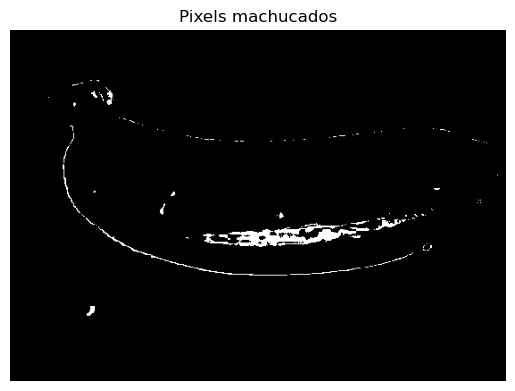

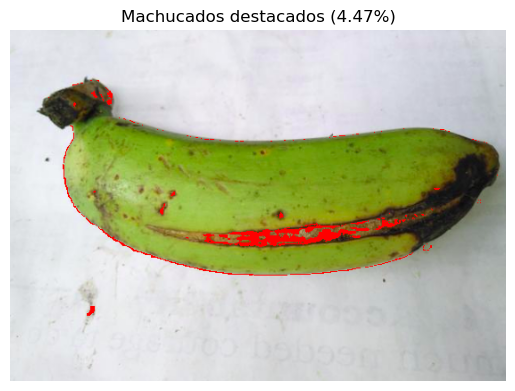

In [212]:
def detectar_machucados(imagem_rgb: np.ndarray, mascara_banana: np.ndarray,
                        limiar_podre_v: float = 0.35,
                        limiar_podre_s: float = 0.25,
                        limiar_cor_s: float = 0.20):
    hsv = rgb_para_hsv(imagem_rgb)
    h = hsv[..., 0]
    s = hsv[..., 1]
    v = hsv[..., 2]

    dentro = mascara_banana.astype(bool)

    # "podre" para excluir escuros (pra não confundir com machucado)
    mascara_podre = dentro & (
        (v < limiar_podre_v) |
        ((v < (limiar_podre_v + 0.08)) & (s < limiar_podre_s))
    )

    # faixas para excluir verde e amarelo
    h_verde_min, h_verde_max = 80/360, 170/360
    h_amarelo_min, h_amarelo_max = 35/360, 80/360

    mascara_verde  = dentro & (~mascara_podre) & (s >= limiar_cor_s) & (h >= h_verde_min) & (h <= h_verde_max)
    mascara_madura = dentro & (~mascara_podre) & (s >= limiar_cor_s) & (h >= h_amarelo_min) & (h <= h_amarelo_max)

    # machucado = o que sobrou dentro da banana
    mascara_machucada = dentro & (~mascara_podre) & (~mascara_verde) & (~mascara_madura)

    total = int(np.sum(dentro))
    perc = 0.0 if total == 0 else 100.0 * float(np.sum(mascara_machucada)) / total

    return mascara_machucada, perc

m_machucada, perc_machucado = detectar_machucados(imagem, mascara_banana)

print("Percentual machucado:", round(perc_machucado, 2), "%")

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(m_machucada, cmap="gray")
plt.title("Pixels machucados")
plt.axis("off")
plt.show()

overlay = imagem.copy()
overlay[m_machucada] = [1.0, 0.0, 0.0]  # pinta de vermelho (se imagem está em float 0..1)

plt.figure()
plt.imshow(overlay)
plt.title(f"Machucados destacados ({perc_machucado:.2f}%)")
plt.axis("off")
plt.show()
